In [21]:
import warnings
import numpy as np
import pandas as pd
import os, json
import matplotlib.pyplot as plt
import seaborn as sns

from joblib import load
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from TrainMLModels import read_json, generate_model_predictions, save_json

from tabulate import tabulate
from texttable import Texttable

import latextable

warnings.filterwarnings('ignore')

In [22]:
data_name = 'meps16'

cur_dir = 'eval/'

mcc_df = pd.read_csv('{}min-{}.csv'.format(cur_dir, data_name))
mcc_df.head(10)

,data,seed,test_n,group_n,sim,sim_n,model,method,correct_n
0,meps16,1,2352,1486,0 to 1,129,lr,MCC-MIN,102
1,meps16,1,2352,1486,0 to 1,129,lr,MCC-W1,106
2,meps16,1,2352,1486,0 to 1,129,lr,MCC-W2,106
3,meps16,1,2352,1486,0 to 1,129,lr,ORIG,99
4,meps16,1,2352,1486,0 to 1,129,lr,SEP,102
5,meps16,1,2352,866,1 to 0,264,lr,MCC-MIN,203
6,meps16,1,2352,866,1 to 0,264,lr,MCC-W1,240
7,meps16,1,2352,866,1 to 0,264,lr,MCC-W2,225
8,meps16,1,2352,866,1 to 0,264,lr,ORIG,240
9,meps16,1,2352,866,1 to 0,264,lr,SEP,218


In [23]:
mcc_df.query('seed==1')

,data,seed,test_n,group_n,sim,sim_n,model,method,correct_n
0,meps16,1,2352,1486,0 to 1,129,lr,MCC-MIN,102
1,meps16,1,2352,1486,0 to 1,129,lr,MCC-W1,106
2,meps16,1,2352,1486,0 to 1,129,lr,MCC-W2,106
3,meps16,1,2352,1486,0 to 1,129,lr,ORIG,99
4,meps16,1,2352,1486,0 to 1,129,lr,SEP,102
5,meps16,1,2352,866,1 to 0,264,lr,MCC-MIN,203
6,meps16,1,2352,866,1 to 0,264,lr,MCC-W1,240
7,meps16,1,2352,866,1 to 0,264,lr,MCC-W2,225
8,meps16,1,2352,866,1 to 0,264,lr,ORIG,240
9,meps16,1,2352,866,1 to 0,264,lr,SEP,218


In [24]:
seeds = [1, 12345, 6, 2211, 15, 88, 121, 433, 500, 1121, 50, 583, 5278, 100000, 0xbeef, 0xcafe, 0xdead, 7777, 100, 923]
# seeds = [88, 121, 433, 500, 1121, 50, 583, 5278, 100000, 0xbeef, 0xcafe, 0xdead, 7777, 100, 923]

models = ['LR', 'TR']

datasets = ['lsac', 'cardio', 'bank', 'meps16', 'credit', 'ACSE', 'ACSP', 'ACSH', 'ACSM', 'ACSI']

all_mcc = pd.DataFrame()
for data_name in datasets:
    mcc_df = pd.read_csv('{}min-{}.csv'.format(cur_dir, data_name))
    all_mcc = pd.concat([all_mcc, mcc_df])
all_mcc['model'] = all_mcc['model'].apply(lambda x: x.upper())

In [25]:
# data_path = 'data/processed/'
# test_sizes = []
# for data_name in datasets:
#     cur_meta = read_json('{}{}.json'.format(data_path, data_name))
#     n_data = cur_meta['size']
#     test_sizes.append(int(n_data*0.15))
# test_sizes

In [26]:
all_mcc.head()

,data,seed,test_n,group_n,sim,sim_n,model,method,correct_n
0,lsac,1,3672,275,0 to 1,2,LR,MCC-MIN,2
1,lsac,1,3672,275,0 to 1,2,LR,MCC-W1,0
2,lsac,1,3672,275,0 to 1,2,LR,MCC-W2,1
3,lsac,1,3672,275,0 to 1,2,LR,ORIG,2
4,lsac,1,3672,275,0 to 1,2,LR,SEP,1


In [27]:
datasets = ['ACSP', 'ACSM']

In [32]:
# first_cols = ['size', '# of attributes (numer./ categ.)', 'minority group U', 'population of U', '% of positive labels in U', 'predictive task']
rows = [['sim', 'method'] + datasets]
# setting = 'err'
model_i = 'LR'
sim_df = pd.DataFrame(columns=['sim', 'method'] + datasets)
# res_path = 'intermediate/models/'
for case_i, case_name in zip(['0 to 1', '1 to 0'], ['unpriv -> priv', 'priv -> unpriv']):
# for case_i, case_name in zip(['0 to 1'], ['unpriv -> priv']):
    
    if model_i == 'LR':
        methods = ['MCC-MIN', 'MCC-W1', 'MCC-W2', 'SEP', 'ORIG', 'OMN-ONE', 'KAM-ONE', 'SCC-KAM']
    else:
        methods = ['MCC-MIN', 'MCC-W1', 'MCC-W2', 'SEP', 'ORIG', 'OMN-ONE', 'KAM-ONE', 'SCC-KAM', 'CAP-ONE']
    for method_i in methods:
        cur_row = [case_name, method_i]
        for data_name in datasets:
            
            cur_df = all_mcc.query('data=="{}" and sim=="{}" and model=="{}" and method=="{}"'.format(data_name, case_i, model_i, method_i))
            if cur_df.shape[0] > 0:
                case_perc = cur_df['sim_n'].values[0]/cur_df['test_n'].values[0]
            else:
                case_perc = 0
                print('no', data_name, model_i, method_i, case_i)
            correct_all = []
            
            for seed_i in seeds:
                seed_df = cur_df.query('seed=={}'.format(seed_i))
                
                if seed_df.shape[0] > 0:
                    case_impr =  seed_df['correct_n'].values[0]/seed_df['sim_n'].values[0]
                    correct_all.append(case_impr)
                else:
                    correct_all.append(0)
                    print('skip', data_name, model_i, seed_i, method_i, case_i)
            if sum(correct_all) > 0:
                correct_mean = round(np.mean(correct_all)*100, 1)
            else:
                correct_mean = 0
            cur_row.append('{}% / {}%'.format(correct_mean, round(case_perc*100, 1)))
            
        sim_df.loc[sim_df.shape[0]] = cur_row
        rows.append(cur_row)
# sim_df.to_csv('eval/sim_{}_{}.csv'.format(setting, model_i), index=False)
#             print(cur_row)
#             break

In [33]:
sim_df

,sim,method,ACSP,ACSM
0,unpriv -> priv,MCC-MIN,58.7% / 32.0%,45.8% / 3.3%
1,unpriv -> priv,MCC-W1,61.5% / 32.0%,45.5% / 3.3%
2,unpriv -> priv,MCC-W2,61.8% / 32.0%,45.5% / 3.3%
3,unpriv -> priv,SEP,59.5% / 32.0%,48.9% / 3.3%
4,unpriv -> priv,ORIG,61.6% / 32.0%,46.2% / 3.3%
5,unpriv -> priv,OMN-ONE,63.7% / 32.0%,49.2% / 3.3%
6,unpriv -> priv,KAM-ONE,59.2% / 32.0%,46.6% / 3.3%
7,unpriv -> priv,SCC-KAM,58.1% / 32.0%,46.6% / 3.3%
8,priv -> unpriv,MCC-MIN,61.8% / 3.8%,0% / 0.0%
9,priv -> unpriv,MCC-W1,50.6% / 3.8%,0% / 0.0%


In [35]:

# rows = [['Rocket', 'Organisation', 'LEO Payload (Tonnes)', 'Maiden Flight'],
#         ['Saturn V', 'NASA', '140', '1967'],
#         ['Space Shuttle', 'NASA', '24.4', '1981'],
#         ['Falcon 9 FT-Expended', 'SpaceX', '22.8', '2017'],
#         ['Ariane 5 ECA', 'ESA', '21', '2002']]


table = Texttable()
table.set_cols_align(["c"] * len(rows[0]))
table.set_deco(Texttable.HEADER | Texttable.VLINES)
table.add_rows(rows)

# print('Tabulate Table:')
# print(tabulate(rows, headers='firstrow'))

# print('\nTexttable Table:')
# print(table.draw())

print('\nTabulate Latex:')
print(tabulate(rows, headers='firstrow', tablefmt='latex'))


Tabulate Latex:
\begin{tabular}{llllllllllll}
\hline
 case           & method   & credit        & cardio       & meps16        & lsac          & bank         & ACSH          & ACSP          & ACSI          & ACSE          & ACSM         \\
\hline
 unpriv -\ensuremath{>} priv & MCC-MIN  & 5.0\% / 2.6\%   & 56.3\% / 0.4\% & 66.2\% / 55.0\% & 37.1\% / 2.3\%  & 75.5\% / 1.4\% & nan\% / 0.0\%   & 67.0\% / 0.7\%  & 43.2\% / 0.0\%  & 71.6\% / 0.1\%  & 71.1\% / 0.4\% \\
 unpriv -\ensuremath{>} priv & MCC-W1   & 85.5\% / 2.6\%  & 48.2\% / 0.4\% & 78.0\% / 55.0\% & 36.3\% / 2.3\%  & 75.2\% / 1.4\% & nan\% / 0.0\%   & 59.3\% / 0.7\%  & 38.3\% / 0.0\%  & 5.7\% / 0.1\%   & 70.0\% / 0.4\% \\
 unpriv -\ensuremath{>} priv & MCC-W2   & 43.7\% / 2.6\%  & 50.3\% / 0.4\% & 68.7\% / 55.0\% & 34.6\% / 2.3\%  & 75.5\% / 1.4\% & nan\% / 0.0\%   & 69.0\% / 0.7\%  & 38.8\% / 0.0\%  & 85.2\% / 0.1\%  & 73.0\% / 0.4\% \\
 unpriv -\ensuremath{>} priv & SEP      & 95.4\% / 2.6\%  & 49.7\% / 0.4\% & 80.6\% / 55.0\%

In [13]:
data_name = 'cardio'
seed = 1
model_name = 'lr'
res_path = 'intermediate/models/'
test_file = '{}/test-{}-{}-multi.csv'.format(res_path+data_name, model_name, seed)
test_df = pd.read_csv(test_file)
test_df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,Y,...,vio_G0_L1,vio_G1_L0,vio_G1_L1,Y_pred,Y_pred_G0,Y_pred_G1,Y_pred_A,Y_pred_min,Y_pred_w1,Y_pred_w2
0,26.912726,110,80,1,1,3,0,0,1,0,...,0.311963,0.511428,0.148063,0,0.169180,0.439278,0,0,0,0
1,26.573129,120,80,1,1,1,0,0,1,0,...,0.141647,0.390809,0.000000,0,0.198492,0.451272,0,0,0,0
2,27.993022,140,90,1,1,1,0,0,1,1,...,0.416437,0.724730,0.066609,0,0.218710,0.473600,0,1,0,0
3,20.202020,120,80,1,2,1,0,0,1,1,...,0.450242,0.479946,0.443531,1,0.267900,0.521049,0,0,0,0
4,23.875115,120,80,1,1,1,0,0,1,0,...,0.000000,0.000000,0.000000,0,0.168860,0.416438,0,0,0,0


## Notes for separability between groups
- No separable case: ACSM and ACSE
- Separable case: ACSP, lsac, 


In [34]:
data_name = 'cardio'
seed = 1
model_name = 'tr'
res_path = 'intermediate/models/'
test_file = '{}/test-{}-{}-multi.csv'.format(res_path+data_name, model_name, seed)
test_df = pd.read_csv(test_file)
test_df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,Y,...,vio_G0_L1,vio_G1_L0,vio_G1_L1,Y_pred,Y_pred_G0,Y_pred_G1,Y_pred_A,Y_pred_min,Y_pred_w1,Y_pred_w2
0,1.0,3.0,1.0,1,1,3,0,0,1,0,...,0.311963,0.511428,0.148063,0,0.197174,0.499140,0,1,0,0
1,1.0,3.0,1.0,1,1,1,0,0,1,0,...,0.141647,0.390809,0.000000,0,0.180490,0.499140,0,1,0,0
2,1.0,4.0,1.0,1,1,1,0,0,1,1,...,0.416437,0.724730,0.066609,1,0.755833,0.501175,1,1,1,1
3,0.0,3.0,1.0,1,2,1,0,0,1,1,...,0.450242,0.479946,0.443531,0,0.133737,0.499140,0,0,0,0
4,0.0,3.0,1.0,1,1,1,0,0,1,0,...,0.000000,0.000000,0.000000,0,0.106830,0.499140,0,0,0,0


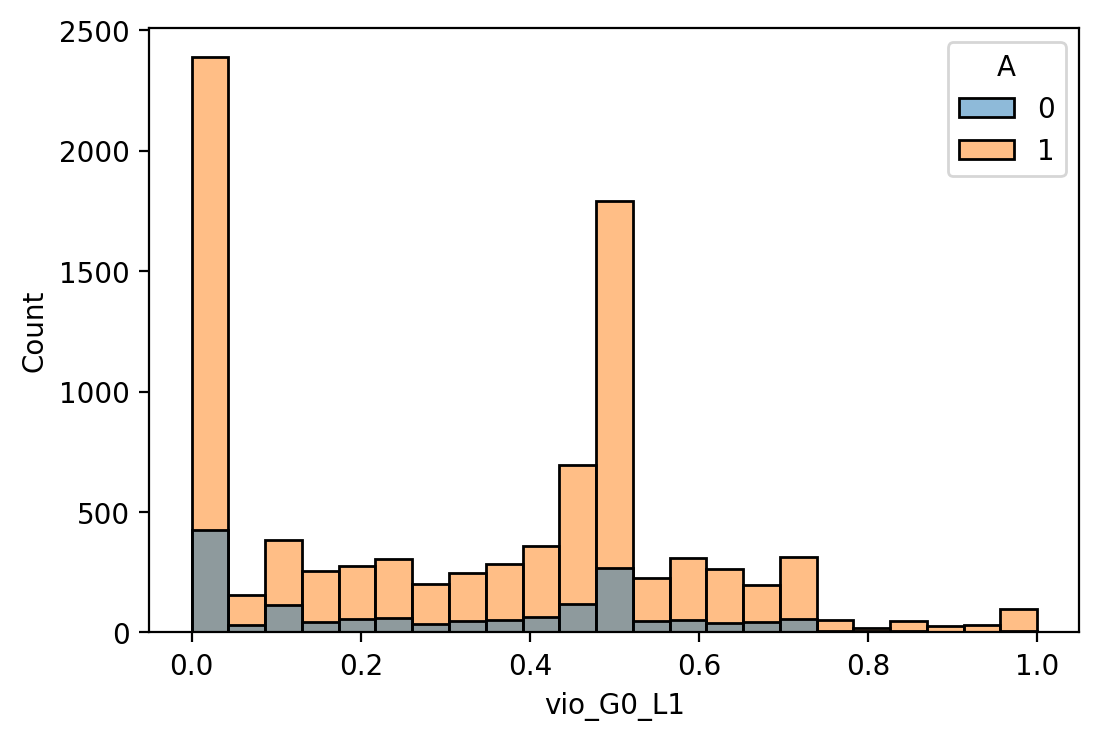

In [35]:
plt.figure(dpi=200)
sns.histplot(x='vio_G0_L1', data=test_df, hue='A')

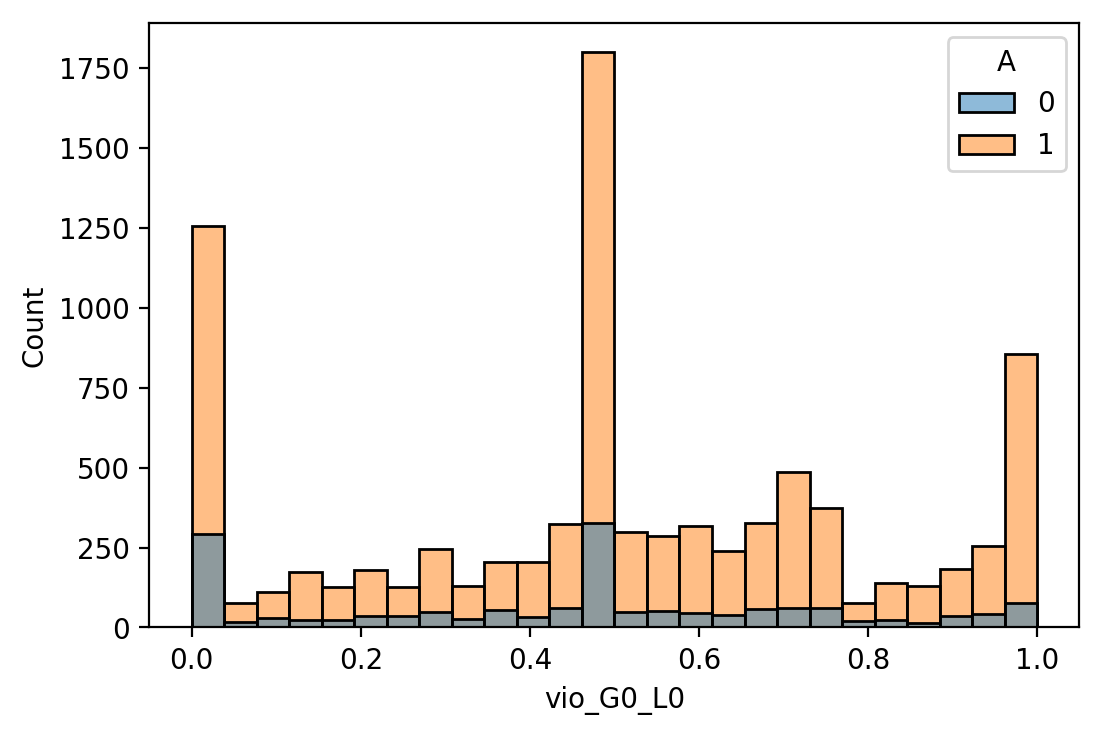

In [36]:
plt.figure(dpi=200)
sns.histplot(x='vio_G0_L0', data=test_df, hue='A')

In [37]:
# get the mean violations of group using other group's CC models to show the separation of groups
# cc_par = read_json('{}par-cc-{}.json'.format(cur_dir, seed))
vio_cols = ['vio_G{}_L{}'.format(group_i, label_i) for group_i in range(2) for label_i in range(2)]

for group_i in range(2):
    for label_i in range(2):
        
        group_df = test_df.query('A=={} and Y=={}'.format(group_i, label_i))
        same_label_vio_col = 'vio_G{}_L{}'.format(abs(1-group_i), label_i)
        opp_label_vio_col = 'vio_G{}_L{}'.format(abs(1-group_i), abs(1-label_i))
        own_same_label = 'vio_G{}_L{}'.format(group_i, label_i)
        own_opp_label = 'vio_G{}_L{}'.format(group_i, abs(1-label_i))
        print(group_i, label_i, 'own group same label', group_df[own_same_label].mean())
        print(group_i, label_i, 'own group opp label', group_df[own_opp_label].mean())
        
        print(group_i, label_i, 'other group same label', group_df[same_label_vio_col].mean())
        print(group_i, label_i, 'other group opp label', group_df[opp_label_vio_col].mean())
        print('---'*10)

0 0 own group same label 0.38348896356091816
0 0 own group opp label 0.2829223555564949
0 0 other group same label 0.3567299781827469
0 0 other group opp label 0.25699332952399834
------------------------------
0 1 own group same label 0.3403100539114014
0 1 own group opp label 0.5746330049002898
0 1 other group same label 0.2887004897415086
0 1 other group opp label 0.5210462857818204
------------------------------
1 0 own group same label 0.37489410609397217
1 0 own group opp label 0.24787142818523714
1 0 other group same label 0.41157627502085525
1 0 other group opp label 0.28231875511378846
------------------------------
1 1 own group same label 0.3103299458787157
1 1 own group opp label 0.5276789054138181
1 1 other group same label 0.35842578767345457
1 1 other group opp label 0.5785378488411023
------------------------------


In [4]:

err_df_m = test_df.query('Y != Y_pred_A and A==1')

In [5]:
m_sim_f = err_df_m.query('vio_G1_L0 > vio_G0_L0 and vio_G1_L1 > vio_G0_L1')

f_plus = m_sim_f.query('Y_pred_min == Y')
print(m_sim_f.shape[0], f_plus.shape[0])

387 36


In [6]:
err_df_f = test_df.query('Y != Y_pred_A and A==0')

In [7]:
f_sim_m = err_df_f.query('vio_G1_L0 < vio_G0_L0 and vio_G1_L1 < vio_G0_L1')

m_plus = f_sim_m.query('Y_pred_min == Y')
print(f_sim_m.shape[0], m_plus.shape[0])

23 15


In [9]:
m_plus.query('Y_pred == Y').shape[0]

15

In [10]:
f_plus.query('Y_pred == Y').shape[0]

11

In [9]:
# TODO: get the above ratio for every datasets

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,vio_G0_L1,vio_G1_L0,vio_G1_L1,Y_pred,Y_pred_G0,Y_pred_G1,Y_pred_min,Y_pred_w1,Y_pred_w2,Y_pred_A
310,0.26,3.5,69,0.12,32.0,697.368406,4,1.0,4,0.0,...,0.178084,0.181890,0.172010,1,0.806777,0.894236,1,0,1,0
456,0.19,3.6,69,0.37,32.0,707.368406,2,1.0,4,0.0,...,0.178084,0.174437,0.172010,1,0.805943,0.893005,1,0,1,0
700,-0.27,3.0,69,-0.60,38.0,742.105244,4,1.0,3,0.0,...,0.178084,0.174437,0.172010,1,0.749993,0.831951,1,0,1,0
1016,0.17,3.3,70,0.02,41.0,819.473663,3,1.0,3,0.0,...,0.178084,0.174437,0.172010,1,0.821267,0.881196,1,1,1,0
1750,-0.27,2.8,67,-0.12,35.0,674.736825,2,0.0,4,0.0,...,0.178084,0.174437,0.172010,1,0.821545,0.859683,1,0,1,0
2228,0.15,3.1,68,-0.10,34.0,688.947352,4,0.0,3,0.0,...,0.178084,0.174437,0.172010,1,0.809932,0.866930,1,0,1,0
2240,0.04,3.4,67,-0.32,30.5,663.684196,4,0.0,5,0.0,...,0.178084,0.174437,0.172010,1,0.819262,0.860304,1,0,1,0
2299,-0.28,3.1,68,-0.67,35.0,704.736825,3,1.0,5,0.0,...,0.178084,0.174437,0.172010,1,0.760641,0.826079,1,0,1,0
2667,0.19,3.3,68,0.47,38.0,772.105244,2,1.0,3,0.0,...,0.178084,0.174437,0.172010,1,0.829379,0.898651,1,0,1,0
2878,0.00,2.9,66,0.00,31.0,621.578933,2,0.0,5,0.0,...,0.178084,0.174437,0.177227,1,0.822680,0.868092,1,0,1,0


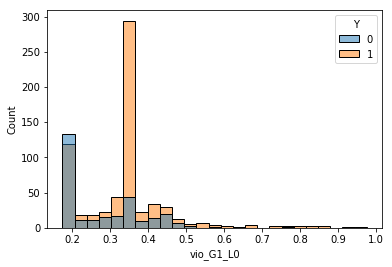

In [12]:
# vis_df = err_df_m.query('Y==0')
sns.histplot(x='vio_G1_L0', data=err_df_m, hue='Y')

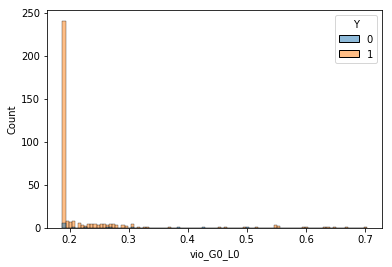

In [15]:
# vis_df = err_df_m.query('Y==0')
sns.histplot(x='vio_G0_L0', data=err_df_f, hue='Y')

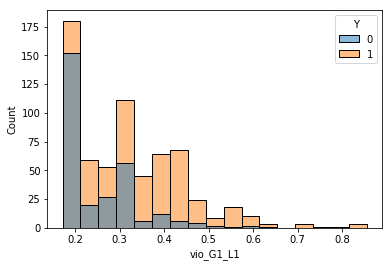

In [16]:
# vis_df = err_df_m.query('Y==0')
sns.histplot(x='vio_G1_L1', data=err_df_m, hue='Y')

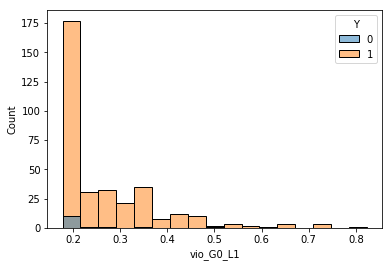

In [17]:
# vis_df = err_df_m.query('Y==0')
sns.histplot(x='vio_G0_L1', data=err_df_f, hue='Y')

In [48]:
err_df_f = test_df.query('Y != Y_pred_F and A==0')

In [28]:
err_df_a = test_df.query('Y != Y_pred_A')
print(err_df_a.shape[0])
err_df_a[['A', 'X1']].groupby(by=['A']).count()

723


,X1
A,
0,176
1,547


In [29]:
err_df_c = test_df.query('Y != Y_pred_C')
print(err_df_c.shape[0])
err_df_c[['A', 'X1']].groupby(by=['A']).count()

767


,X1
A,
0,177
1,590


In [30]:
err_df_w = test_df.query('Y != Y_pred_W')
print(err_df_w.shape[0])
err_df_w[['A', 'X1']].groupby(by=['A']).count()

3300


,X1
A,
0,507
1,2793


In [31]:
err_df_w2 = test_df.query('Y != Y_pred_W2')
print(err_df_w2.shape[0])
err_df_w2[['A', 'X1']].groupby(by=['A']).count()

715


,X1
A,
0,170
1,545


In [32]:
err_df_o = test_df.query('Y != Y_pred_O')
print(err_df_o.shape[0])
err_df_o[['A', 'X1']].groupby(by=['A']).count()

890


,X1
A,
0,245
1,645


In [36]:
diff_ac = set(err_df_a.index).difference(err_df_c.index)
len(diff_ac), err_df_a.shape[0], err_df_c.shape[0]

(34, 723, 767)

In [37]:
diff_aw = set(err_df_a.index).difference(err_df_w.index)
len(diff_aw), err_df_a.shape[0], err_df_w.shape[0]

(611, 723, 3300)

In [38]:
diff_aw2 = set(err_df_a.index).difference(err_df_w2.index)
len(diff_aw2), err_df_a.shape[0], err_df_w2.shape[0]

(62, 723, 715)

In [39]:
diff_ow2 = set(err_df_o.index).difference(err_df_w2.index)
len(diff_ow2), err_df_a.shape[0], err_df_w2.shape[0]

(327, 723, 715)

In [41]:
df_aw2 = err_df_a.loc[diff_aw2, :]
df_aw2[['A', 'X1']].groupby(by=['A']).count()

,X1
A,
0,27
1,35


In [42]:
df_ow2 = err_df_o.loc[diff_ow2, :]
df_ow2[['A', 'X1']].groupby(by=['A']).count()

,X1
A,
0,135
1,192


In [43]:
diff_w2a = set(err_df_w2.index).difference(err_df_a.index)
len(diff_w2a), err_df_w2.shape[0], err_df_a.shape[0]

(54, 715, 723)

In [44]:
diff_w2o = set(err_df_w2.index).difference(err_df_o.index)
len(diff_w2o), err_df_w2.shape[0], err_df_o.shape[0]

(152, 715, 890)

In [45]:
df_w2a = err_df_w2.loc[diff_w2a, :]
df_w2a[['A', 'X1']].groupby(by=['A']).count()

,X1
A,
0,21
1,33


In [46]:
df_w2o = err_df_w2.loc[diff_w2o, :]
df_w2o[['A', 'X1']].groupby(by=['A']).count()

,X1
A,
0,60
1,92


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

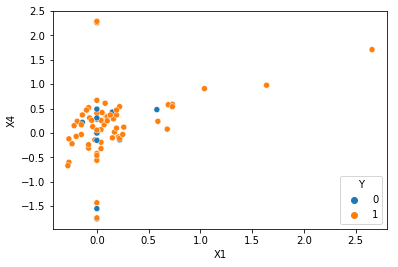

In [59]:
# vis_col = 'Y_pred'
vis_df = test_df.query('A==0 and vio_G0_L1 > vio_G1_L1 and vio_G0_L0 > vio_G1_L0')
sns.scatterplot(x='X1', y='X4', data=vis_df, hue='Y')

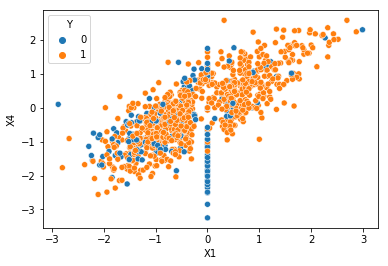

In [58]:
# vis_col = 'Y_pred'
vis_df = test_df.query('A==1 and vio_G0_L1 < vio_G1_L1 and vio_G0_L0 < vio_G1_L0')
sns.scatterplot(x='X1', y='X4', data=vis_df, hue='Y')

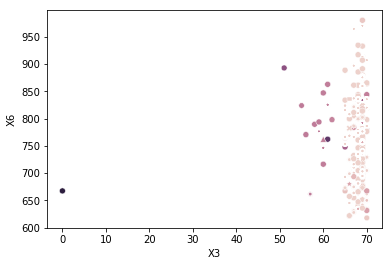

In [49]:
# vis_col = 'Y_pred'
vis_df = test_df.query('A==0 and Y==1 and vio_G0_L1 > vio_G1_L1')
sns.scatterplot(x='X3', y='X6', data=vis_df, hue='vio_G0_L1', style='Y_pred_G0', legend=None)

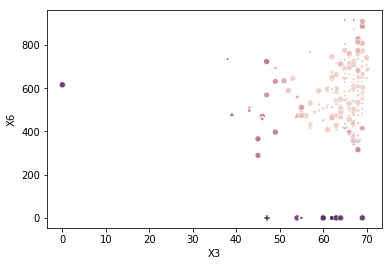

In [44]:
# vis_col = 'Y_pred'
vis_df = test_df.query('A==0 and Y==0')
sns.scatterplot(x='X3', y='X6', data=vis_df, hue='vio_G0_L0', style='Y_pred_G0', legend=None)

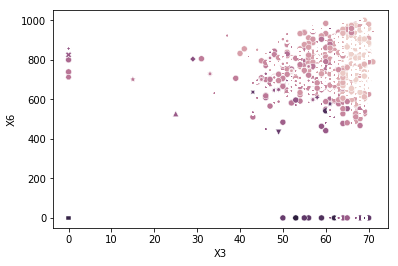

In [46]:
# vis_col = 'Y_pred'
vis_df = test_df.query('A==1 and Y==1')
sns.scatterplot(x='X3', y='X6', data=vis_df, hue='vio_G1_L1', style='Y_pred_G1', legend=None)

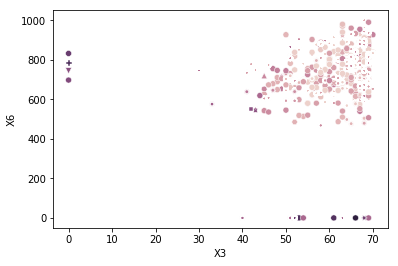

In [48]:
# vis_col = 'Y_pred'
vis_df = test_df.query('A==1 and Y==0')
sns.scatterplot(x='X3', y='X6', data=vis_df, hue='vio_G1_L0', style='Y_pred_G1', legend=None)

In [ ]:
# vis_col = 'Y_pred'
vis_df = test_df.query('A==0')
sns.scatterplot(x='X1', y='X6', data=vis_df, hue='vio_G0_L1', style='Y_pred_G0', legend=None)

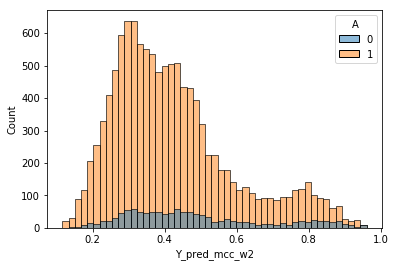

In [16]:
vis_col = 'Y_pred_mcc_w2'
sns.histplot(x=vis_col, data=test_df, hue='A')

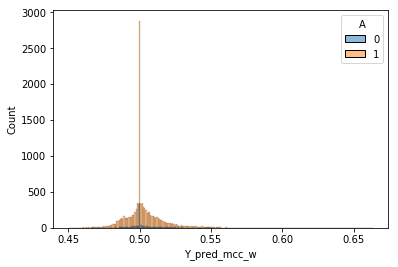

In [17]:
vis_col = 'Y_pred_mcc_w'
sns.histplot(x=vis_col, data=test_df, hue='A')

In [18]:
def compute_bal_acc(y_true, y_pred, label_order=[0, 1]):
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred, labels=label_order).ravel()
    P = TP + FN
    N = TN + FP
    TPR = TP / P if P > 0.0 else np.float64(0.0)
    TNR = TN / N if N > 0.0 else np.float64(0.0)
    return 0.5 * (TPR + TNR)
def compute_sr(y_true, y_pred, label_order=[0, 1]):
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred, labels=label_order).ravel()
    pred_P = TP+FP
    P = TP + FN
    N = TN + FP
    return pred_P / (P+N)
def eval_sp(test_eval_df, pred_col, sensi_col='A', n_groups=2):
    SR_all = []
    for group_i in range(n_groups):
        group_df = test_eval_df[test_eval_df[sensi_col] == group_i]
        group_sr = compute_sr(group_df['Y'], group_df[pred_col])
        SR_all.append(group_sr)

    sp_diff = SR_all[0] - SR_all[1]
    return sp_diff

In [19]:
acc_a = compute_bal_acc(test_df['Y'], test_df['Y_pred_O'])
sp_a = eval_sp(test_df, 'Y_pred_O')
acc_a, sp_a

(0.6488503000777103, 0.4138896649932855)

In [20]:
acc_a = compute_bal_acc(test_df['Y'], test_df['Y_pred_A'])
sp_a = eval_sp(test_df, 'Y_pred_A')
acc_a, sp_a

(0.652425532737809, 0.2841042880942658)

In [21]:
acc_a = compute_bal_acc(test_df['Y'], test_df['Y_pred_M'])
sp_a = eval_sp(test_df, 'Y_pred_M')
acc_a, sp_a

(0.6304971116916057, 0.13079564528015675)

In [22]:
acc_a = compute_bal_acc(test_df['Y'], test_df['Y_pred_W'])
sp_a = eval_sp(test_df, 'Y_pred_W')
acc_a, sp_a

(0.5, 0.0)

In [23]:
acc_a = compute_bal_acc(test_df['Y'], test_df['Y_pred_W2'])
sp_a = eval_sp(test_df, 'Y_pred_W2')
acc_a, sp_a

(0.6269689657611663, 0.1267807782782593)